In [4]:
!pip install -U imbalanced-learn
!pip install -U xgboost


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_csv('Data for Postpartum Depression Prediction in Bangladesh/PPD_dataset.csv')
print(f"Dataset shape: {df.shape}")
print(df.head())

Dataset shape: (800, 51)
   sr  Age Residence Education Level Marital status  \
0   1   24      City      University        Married   
1   2   31      City      University       Divorced   
2   3   31      City      University        Married   
3   4   32      City      University        Married   
4   5   27      City      University        Married   

  Occupation before latest pregnancy Monthly income before latest pregnancy  \
0                            Student                                    NaN   
1                             Doctor                         10000 to 20000   
2                            Service                         10000 to 20000   
3                             Doctor                        More than 30000   
4                          Housewife                                    NaN   

  Occupation After Your Latest Childbirth Current monthly income  \
0                                 Student                    NaN   
1                                

In [3]:
print(df.info())
print(df.describe(include='all'))
print("\nMissing values per column:")
print(df.isnull().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 51 columns):
 #   Column                                    Non-Null Count  Dtype 
---  ------                                    --------------  ----- 
 0   sr                                        800 non-null    int64 
 1   Age                                       800 non-null    int64 
 2   Residence                                 800 non-null    object
 3   Education Level                           794 non-null    object
 4   Marital status                            800 non-null    object
 5   Occupation before latest pregnancy        800 non-null    object
 6   Monthly income before latest pregnancy    363 non-null    object
 7   Occupation After Your Latest Childbirth   800 non-null    object
 8   Current monthly income                    275 non-null    object
 9   Husband's education level                 791 non-null    object
 10  Husband’s monthly income                  772 non-

In [4]:
def handle_missing_values(df):
    df_clean = df.copy()
    categorical_columns = df_clean.select_dtypes(include=['object']).columns
    for col in categorical_columns:
        df_clean[col] = df_clean[col].fillna(df_clean[col].mode()[0])
    numerical_columns = df_clean.select_dtypes(include=['int64', 'float64']).columns
    for col in numerical_columns:
        df_clean[col] = df_clean[col].fillna(df_clean[col].median())
    return df_clean

df_clean = handle_missing_values(df)
print("\nMissing values after cleaning:")
print(df_clean.isnull().sum())
print(df_clean)


Missing values after cleaning:
sr                                          0
Age                                         0
Residence                                   0
Education Level                             0
Marital status                              0
Occupation before latest pregnancy          0
Monthly income before latest pregnancy      0
Occupation After Your Latest Childbirth     0
Current monthly income                      0
Husband's education level                   0
Husband’s monthly income                    0
Addiction                                   0
Total children                              0
Disease before pregnancy                    0
History of pregnancy loss                   0
Family type                                 0
Number of household members                 0
Relationship with the in-laws               0
Relationship with husband                   0
Relationship with the newborn               0
Relationship between father and newborn     0
Fe

In [5]:
def text_to_number(val):
    if pd.isnull(val):
        return np.nan
    val = str(val).strip().lower()
    word_map = {'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5,
                'six': 6, 'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10,
                'more than two': 3, 'more than 2': 3, 'more than five': 6,
                'more than 5': 6, 'more than six': 7, 'more than 6': 7,
                'more than eight': 9, 'more than 8': 9, 'none': 0}
    if val in word_map:
        return word_map[val]
    if 'to' in val:
        parts = val.replace('+', '').split('to')
        try:
            return (float(parts[0].strip()) + float(parts[1].strip())) / 2
        except:
            return np.nan
    if 'month' in val:
        nums = [int(s) for s in val.split() if s.isdigit()]
        return nums[0] if nums else np.nan
    if 'year' in val:
        nums = [int(s) for s in val.split() if s.isdigit()]
        return nums[0] * 12 if nums else np.nan
    try:
        return float(val)
    except:
        return np.nan
    

In [6]:
def create_new_features(df):
    df_features = df.copy()
    df_features['Age_Group'] = pd.cut(df_features['Age'], bins=[0, 25, 30, 35, 100], labels=['18-25', '26-30', '31-35', '36+'])
    
    income_mapping = {
        'None': 0,
        'Less than 5000': 2500,
        '5000 to 10000': 7500,
        '10000 to 20000': 15000,
        '20000 to 30000': 25000,
        'More than 30000': 35000
    }
    df_features['Income_Before_Num'] = df_features['Monthly income before latest pregnancy'].map(income_mapping)
    df_features['Income_After_Num'] = df_features['Current monthly income'].map(income_mapping)
    df_features['Income_Change'] = df_features['Income_After_Num'] - df_features['Income_Before_Num']
    
    support_mapping = {'None': 0, 'Low': 1, 'Medium': 2, 'High': 3}
    df_features['Support_Score'] = df_features['Recieved Support'].map(support_mapping)
    
    df_features['Total children'] = df_features['Total children'].apply(text_to_number)
    df_features['Number of household members'] = df_features['Number of household members'].apply(text_to_number)
    df_features['Pregnancy length'] = df_features['Pregnancy length'].apply(text_to_number)

    df_features['Age_Support_Interaction'] = df_features['Age'] * df_features['Support_Score']
    df_features['Income_Children_Interaction'] = df_features['Income_After_Num'] * df_features['Total children']
    df_features['Support_Children_Interaction'] = df_features['Support_Score'] * df_features['Total children']

    numerical_cols = ['Age', 'Income_After_Num', 'Support_Score', 'Total children']
    for col in numerical_cols:
        df_features[f'{col}_squared'] = df_features[col] ** 2

    return df_features

df_features = create_new_features(df_clean)
print("\nSample of engineered features:")
print(df_features[['Age', 'Age_Group', 'Income_Before_Num', 'Income_After_Num', 'Income_Change', 'Support_Score']].head())



Sample of engineered features:
   Age Age_Group  Income_Before_Num  Income_After_Num  Income_Change  \
0   24     18-25              15000             15000              0   
1   31     31-35              15000             15000              0   
2   31     31-35              15000             15000              0   
3   32     31-35              35000             35000              0   
4   27     26-30              15000             15000              0   

   Support_Score  
0              3  
1              2  
2              3  
3              2  
4              2  


In [7]:
model_features = [
    'Age', 'Income_Before_Num', 'Income_After_Num', 'Income_Change',
    'Support_Score', 'Total children', 'Number of household members',
    'Pregnancy length'
]
df_features[model_features] = df_features[model_features].fillna(df_features[model_features].median())


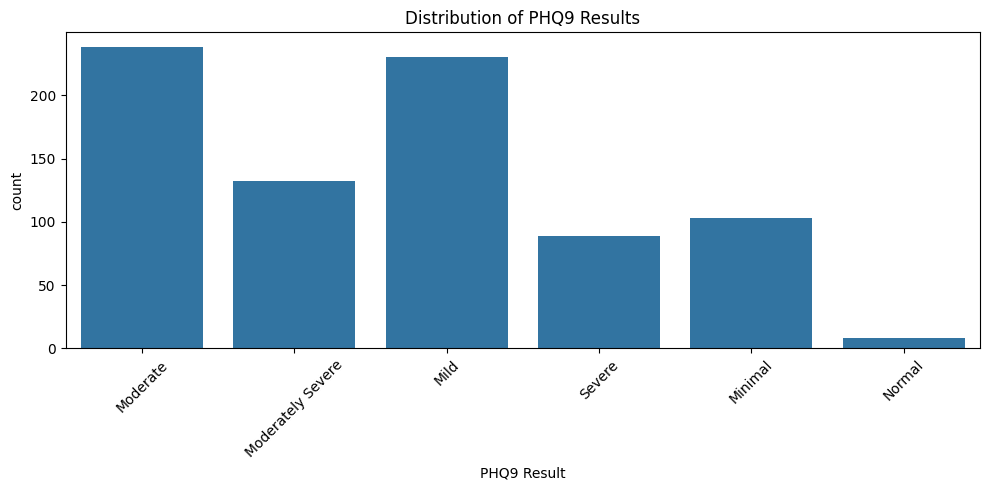

In [8]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df_features, x='PHQ9 Result')
plt.title('Distribution of PHQ9 Results')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


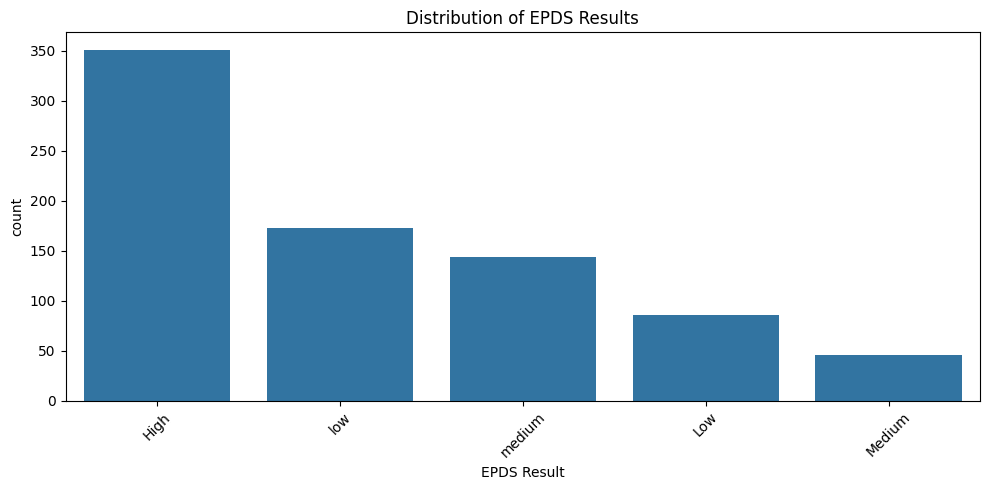

In [9]:
plt.figure(figsize=(10, 5))
sns.countplot(data=df_features, x='EPDS Result')
plt.title('Distribution of EPDS Results')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


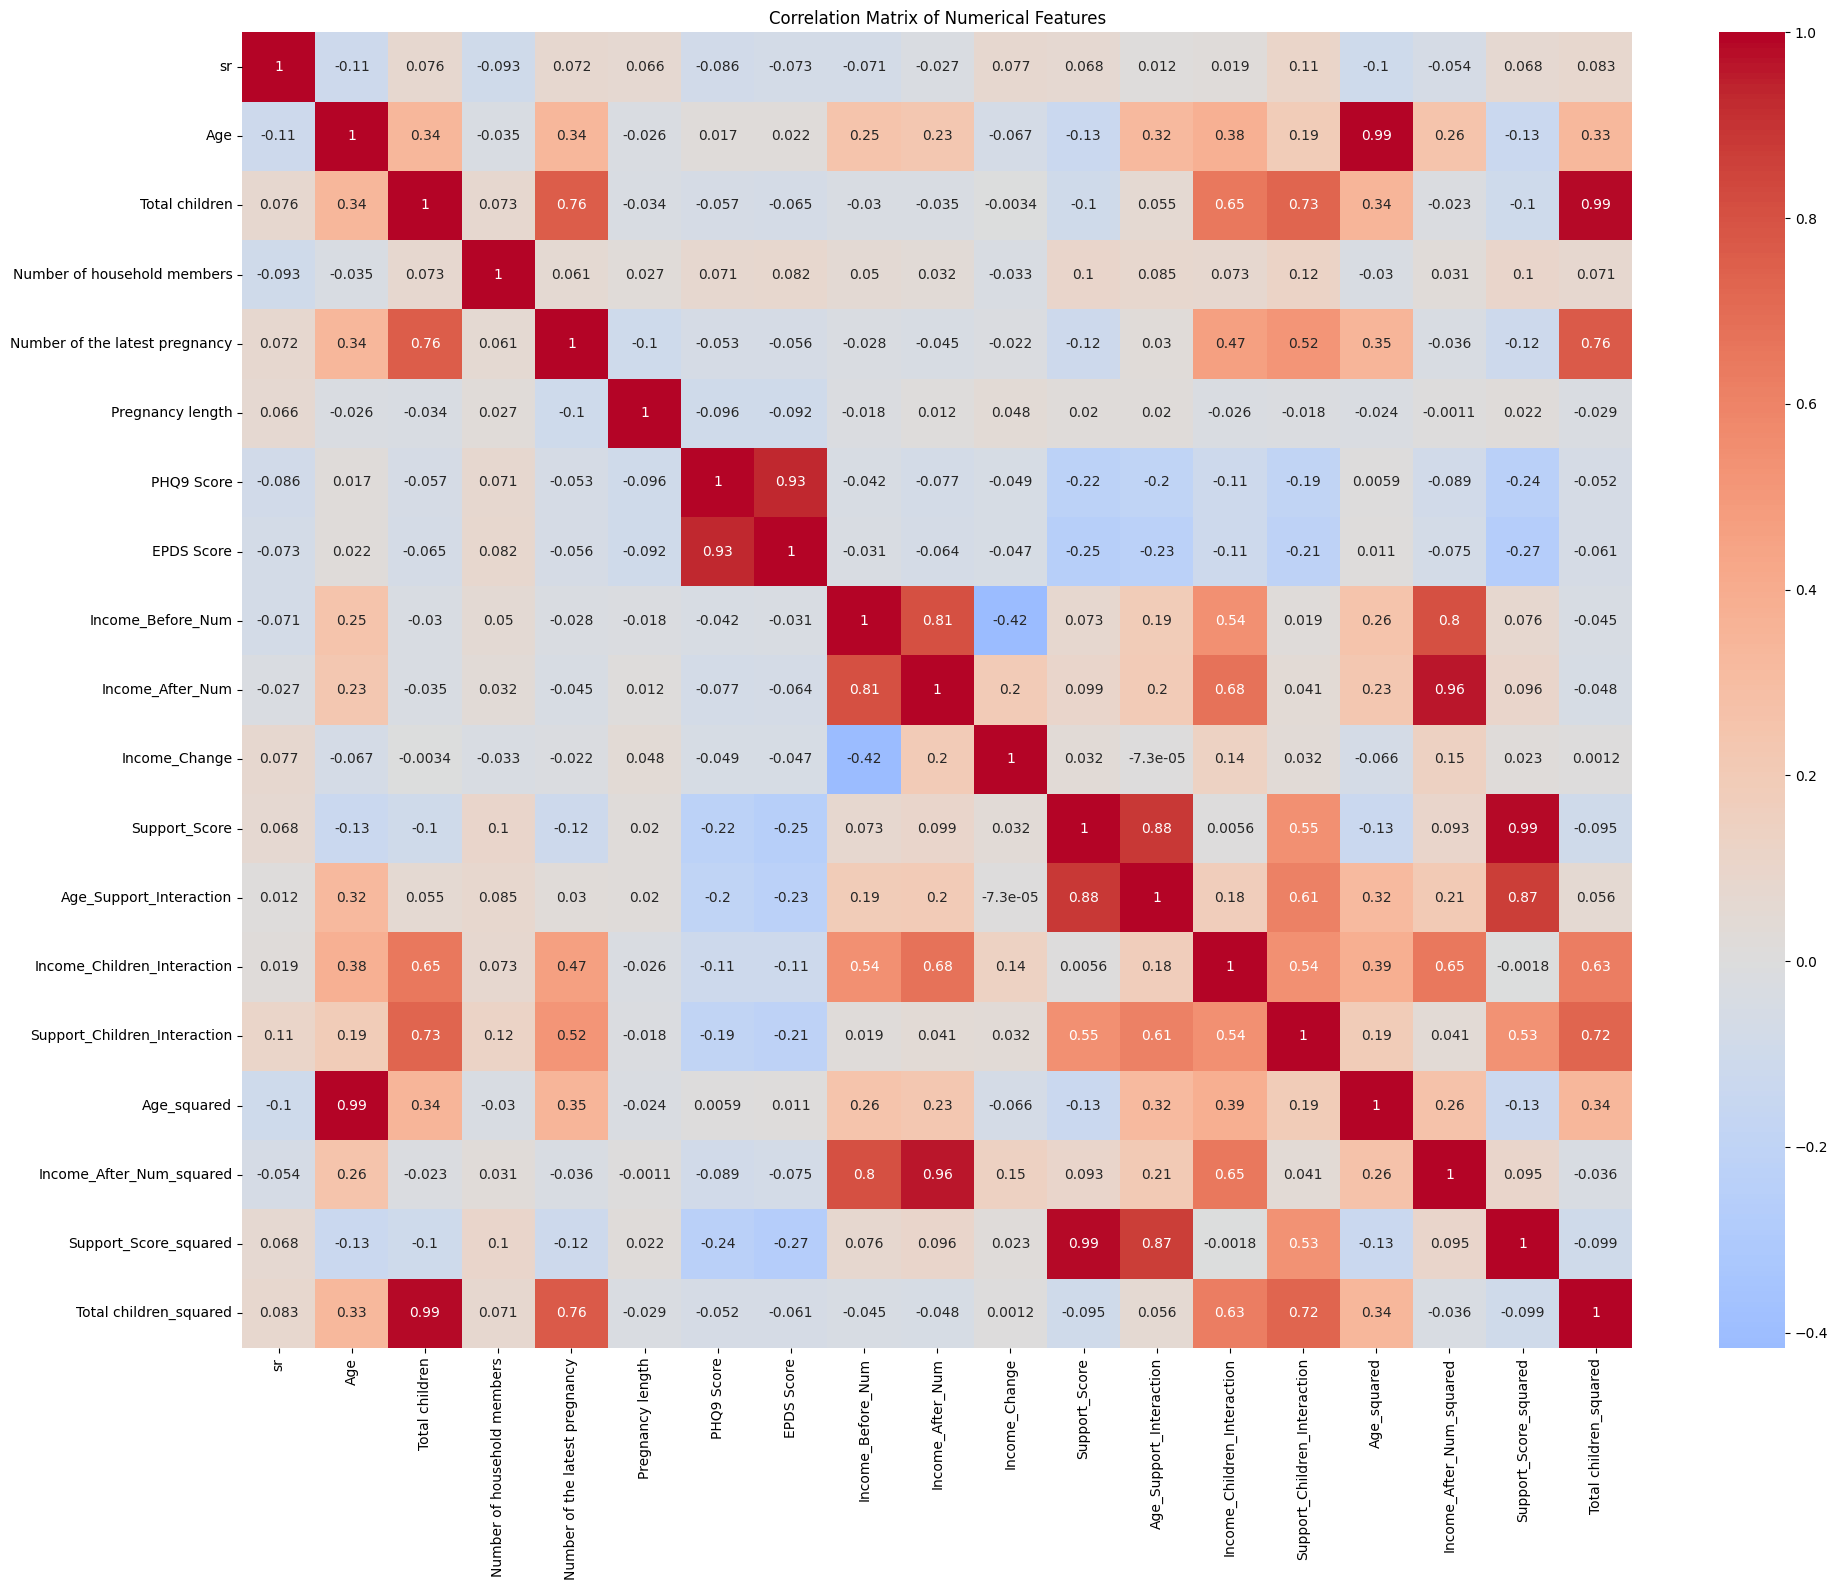

In [10]:
plt.figure(figsize=(20, 16))
correlation_matrix = df_features.select_dtypes(include=['int64', 'float64']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix of Numerical Features')
plt.tight_layout()
plt.show()


In [11]:
def prepare_data_for_modeling(df, target_column):
    numerical_features = [
        'Age', 'Income_Before_Num', 'Income_After_Num', 'Income_Change',
        'Support_Score', 'Total children', 'Number of household members',
        'Pregnancy length', 'Age_Support_Interaction', 'Income_Children_Interaction',
        'Support_Children_Interaction'
    ]

    categorical_features = [
        'Education Level', 'Marital status', 'Residence', 'Family type',
        'Relationship with husband', 'Relationship with the in-laws',
        'Relationship with the newborn', 'Feeling about motherhood',
        'Recieved Support', 'Depression before pregnancy', 'Depression during pregnancy',
        'Trust and share feelings', 'Abuse', 'Need for Support',
        'Major changes or losses during pregnancy', 'Pregnancy plan', 'Regular checkups',
        'Fear of pregnancy', 'Mode of delivery', 'Gender of newborn',
        'Birth compliancy', 'Breastfeed', 'Newborn illness', 'Worry about newborn',
        'Angry after latest child birth'
    ]

    numerical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    preprocessor = ColumnTransformer([
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

    y = df[target_column]
    if y.dtype == 'O':
        le = LabelEncoder()
        y = le.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(
        df, y, test_size=0.2, random_state=42, stratify=y
    )

    return X_train, X_test, y_train, y_test, preprocessor


In [28]:
def train_and_evaluate_models(X_train, X_test, y_train, y_test, preprocessor):
    models = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=2000),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l1', 'l2', 'elasticnet', 'none'],
            'solver': ['saga', 'liblinear', 'lbfgs'],
            'l1_ratio': [None, 0.1, 0.5, 0.7],  
            'class_weight': ['balanced', None],
            'max_iter': [1000, 2000],
            'tol': [1e-4, 1e-3]
        }   
    },

    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2', 0.5],
            'bootstrap': [True, False],
            'criterion': ['gini', 'entropy'],
            'class_weight': ['balanced', None]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'subsample': [0.6, 0.8, 1.0],
            'max_features': ['auto', 'sqrt', None],
            'loss': ['deviance', 'exponential']
        }
    },
    'SVC': {
        'model': SVC(probability=True),
        'params': {
            'C': [0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
            'degree': [2, 3, 4],  # for poly kernel
            'coef0': [0.0, 0.1, 0.5],  # for poly and sigmoid
            'class_weight': ['balanced', None]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'min_child_weight': [1, 3, 5],
            'gamma': [0, 0.1, 0.3],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'reg_alpha': [0, 0.01, 0.1],
            'reg_lambda': [1, 1.5, 2],
            'scale_pos_weight': [1, 2, 5]
        }
    }
    }




    best_models = {}

    for name, model_info in models.items():
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model_info['model'])
        ])

        grid_search = GridSearchCV(
            pipeline,
            param_grid={'model__' + k: v for k, v in model_info['params'].items()},
            cv=5,
            scoring='accuracy',
            n_jobs=-1
        )

        grid_search.fit(X_train, y_train)
        best_models[name] = grid_search.best_estimator_

        y_pred = grid_search.predict(X_test)
        acc = accuracy_score(y_test, y_pred)
        print(f"\n{name} Best Parameters: {grid_search.best_params_}")
        print(f"{name} Accuracy: {acc:.4f}")
        print(classification_report(y_test, y_pred))

        cv_scores = cross_val_score(grid_search.best_estimator_, X_train, y_train, cv=5)
        print(f"{name} CV Score: {cv_scores.mean():.4f} ± {cv_scores.std() * 2:.4f}")

    voting_clf = VotingClassifier(
        estimators=[(name, model) for name, model in best_models.items()],
        voting='soft'
    )
    voting_clf.fit(X_train, y_train)
    y_pred_voting = voting_clf.predict(X_test)
    acc_voting = accuracy_score(y_test, y_pred_voting)
    print("\nVoting Classifier Accuracy:", acc_voting)
    print(classification_report(y_test, y_pred_voting))


In [29]:
X_train_phq9, X_test_phq9, y_train_phq9, y_test_phq9, preprocessor = prepare_data_for_modeling(df_features, 'PHQ9 Result')
train_and_evaluate_models(X_train_phq9, X_test_phq9, y_train_phq9, y_test_phq9, preprocessor)



Logistic Regression Best Parameters: {'model__C': 0.1, 'model__class_weight': None, 'model__l1_ratio': None, 'model__max_iter': 1000, 'model__penalty': 'l2', 'model__solver': 'liblinear', 'model__tol': 0.0001}
Logistic Regression Accuracy: 0.3688
              precision    recall  f1-score   support

           0       0.42      0.52      0.47        46
           1       0.38      0.15      0.21        20
           2       0.35      0.54      0.42        48
           3       0.36      0.15      0.22        26
           4       0.00      0.00      0.00         2
           5       0.22      0.11      0.15        18

    accuracy                           0.37       160
   macro avg       0.29      0.25      0.24       160
weighted avg       0.36      0.37      0.34       160

Logistic Regression CV Score: 0.4281 ± 0.0774

Random Forest Best Parameters: {'model__bootstrap': True, 'model__class_weight': None, 'model__criterion': 'gini', 'model__max_depth': 10, 'model__max_features': 

ValueError: 
All the 14580 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5452 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'loss' parameter of GradientBoostingClassifier must be a str among {'exponential', 'log_loss'}. Got 'deviance' instead.

--------------------------------------------------------------------------------
1838 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'loss' parameter of GradientBoostingClassifier must be a str among {'log_loss', 'exponential'}. Got 'deviance' instead.

--------------------------------------------------------------------------------
1804 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of GradientBoostingClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'sqrt', 'log2'} or None. Got 'auto' instead.

--------------------------------------------------------------------------------
626 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1382, in wrapper
    estimator._validate_params()
  File "c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\_param_validation.py", line 98, in validate_parameter_constraints
    raise InvalidParameterError(
sklearn.utils._param_validation.InvalidParameterError: The 'max_features' parameter of GradientBoostingClassifier must be an int in the range [1, inf), a float in the range (0.0, 1.0], a str among {'log2', 'sqrt'} or None. Got 'auto' instead.

--------------------------------------------------------------------------------
4860 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\pipeline.py", line 662, in fit
    self._final_estimator.fit(Xt, y, **last_step_params["fit"])
  File "c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_gb.py", line 677, in fit
    self._loss = self._get_loss(sample_weight=sample_weight)
                 ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\user1\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\ensemble\_gb.py", line 1549, in _get_loss
    raise ValueError(
ValueError: loss='exponential' is only suitable for a binary classification problem, you have n_classes=6. Please use loss='log_loss' instead.


In [14]:
X_train_epds, X_test_epds, y_train_epds, y_test_epds, preprocessor = prepare_data_for_modeling(df_features, 'EPDS Result')
train_and_evaluate_models(X_train_epds, X_test_epds, y_train_epds, y_test_epds, preprocessor)



Random Forest Best Parameters: {'model__class_weight': 'balanced', 'model__max_depth': 20, 'model__min_samples_split': 2, 'model__n_estimators': 100}
Random Forest Accuracy: 0.5250
              precision    recall  f1-score   support

           0       0.62      0.86      0.72        70
           1       0.31      0.24      0.27        17
           2       0.00      0.00      0.00         9
           3       0.42      0.51      0.46        35
           4       0.25      0.07      0.11        29

    accuracy                           0.53       160
   macro avg       0.32      0.34      0.31       160
weighted avg       0.44      0.53      0.47       160

Random Forest CV Score: 0.5672 ± 0.1011

Gradient Boosting Best Parameters: {'model__learning_rate': 0.01, 'model__max_depth': 3, 'model__n_estimators': 100}
Gradient Boosting Accuracy: 0.5312
              precision    recall  f1-score   support

           0       0.58      0.89      0.70        70
           1       0.12    

In [15]:
print(df_features['PHQ9 Result'].value_counts())


PHQ9 Result
Moderate             238
Mild                 230
Moderately Severe    132
Minimal              103
Severe                89
Normal                 8
Name: count, dtype: int64


In [16]:
# Convert PHQ9 to binary
df_features['PHQ9_Binary'] = df_features['PHQ9 Result'].apply(lambda x: 1 if x in ['Moderate', 'Moderately Severe', 'Severe'] else 0)

# Features to use
features = model_features + [
    'Age_Support_Interaction', 'Income_Children_Interaction', 
    'Support_Children_Interaction'
]

df_model = df_features.dropna(subset=features + ['PHQ9_Binary'])
X = df_model[features]
y = df_model['PHQ9_Binary']


In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Scale data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train_scaled, y_train)


In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

models_params = {
    'Logistic Regression': {
        'model': LogisticRegression(max_iter=2000),
        'params': {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l1', 'l2', 'elasticnet', 'none'],
            'solver': ['saga', 'liblinear', 'lbfgs'],
            'l1_ratio': [None, 0.1, 0.5, 0.7],  
            'class_weight': ['balanced', None],
            'max_iter': [1000, 2000],
            'tol': [1e-4, 1e-3]
        }   
    },

    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'max_features': ['auto', 'sqrt', 'log2', 0.5],
            'bootstrap': [True, False],
            'criterion': ['gini', 'entropy'],
            'class_weight': ['balanced', None]
        }
    },
    'Gradient Boosting': {
        'model': GradientBoostingClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4],
            'subsample': [0.6, 0.8, 1.0],
            'max_features': ['auto', 'sqrt', None],
            'loss': ['deviance', 'exponential']
        }
    },
    'SVC': {
        'model': SVC(probability=True),
        'params': {
            'C': [0.1, 1, 10, 100],
            'kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
            'gamma': ['scale', 'auto', 0.001, 0.01, 0.1],
            'degree': [2, 3, 4],  # for poly kernel
            'coef0': [0.0, 0.1, 0.5],  # for poly and sigmoid
            'class_weight': ['balanced', None]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'params': {
            'n_estimators': [100, 200, 300],
            'learning_rate': [0.01, 0.1, 0.2],
            'max_depth': [3, 5, 7],
            'min_child_weight': [1, 3, 5],
            'gamma': [0, 0.1, 0.3],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'reg_alpha': [0, 0.01, 0.1],
            'reg_lambda': [1, 1.5, 2],
            'scale_pos_weight': [1, 2, 5]
        }
    }




}


In [21]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

best_models = {}

for name, config in models_params.items():
    print(f"\nTraining: {name}")
    grid = GridSearchCV(config['model'], config['params'], scoring='accuracy', cv=5, n_jobs=-1)
    grid.fit(X_train_bal, y_train_bal)
    
    best_model = grid.best_estimator_
    best_models[name] = best_model
    
    # Evaluate on test set
    y_pred = best_model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    print("Best Params:", grid.best_params_)
    print("Test Accuracy:", acc)
    print(classification_report(y_test, y_pred))



Training: Logistic Regression
Best Params: {'C': 0.1, 'class_weight': None, 'l1_ratio': 0.5, 'max_iter': 1000, 'penalty': 'elasticnet', 'solver': 'saga', 'tol': 0.0001}
Test Accuracy: 0.65
              precision    recall  f1-score   support

           0       0.58      0.62      0.60        68
           1       0.70      0.67      0.69        92

    accuracy                           0.65       160
   macro avg       0.64      0.65      0.64       160
weighted avg       0.65      0.65      0.65       160


Training: Random Forest
Best Params: {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}
Test Accuracy: 0.58125
              precision    recall  f1-score   support

           0       0.51      0.53      0.52        68
           1       0.64      0.62      0.63        92

    accuracy                           0.58       160
   macro avg       0

In [22]:
from sklearn.ensemble import VotingClassifier

voting = VotingClassifier(
    estimators=[(name, model) for name, model in best_models.items()],
    voting='soft'
)
voting.fit(X_train_bal, y_train_bal)
y_pred_voting = voting.predict(X_test_scaled)

print("\nEnsemble Voting Classifier:")
print("Accuracy:", accuracy_score(y_test, y_pred_voting))
print(classification_report(y_test, y_pred_voting))



Ensemble Voting Classifier:
Accuracy: 0.59375
              precision    recall  f1-score   support

           0       0.52      0.53      0.53        68
           1       0.65      0.64      0.64        92

    accuracy                           0.59       160
   macro avg       0.59      0.59      0.59       160
weighted avg       0.59      0.59      0.59       160

